# 1 Design gait and basic functions

In [1]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt
plt.ion()

# for the symbolic manipulation of jacobian
import sympy as sp
# from sympy import symbols
# from sympy import sin, cos, asin, acos, pi, atan2, sqrt
from sympy.utilities.lambdify import lambdify
# from sympy import Matrix

from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy import interpolate

In [2]:
## Motor constants
K = 0.0285;                 # Nm / A
peak_amp = 30;              # A
peak_torque = K * peak_amp; # Nm
m_motor = 0.2;              # kg
m_assembly = 0.2;           # kg

m_total = 2*m_motor + m_assembly; # kg

gravity = 9.8;              # m/s^2

weight = m_total * gravity  # N

l1 = 0.09;                  # m 
l2 = 0.16;                  # m
w = 0.07;                   # m

T = 0.25;                   # s
d = 0.5;
N = 100;

In [3]:
# solve jacobian of constraint equation
(thetaL_sym, 
 thetaR_sym, 
 link1_sym, 
 link2_sym, 
 width_sym) = sp.symbols("""thetaL_sym 
                            thetaR_sym 
                            link1_sym 
                            link2_sym 
                            width_sym""", real = True)

In [4]:
def T(theta, x, y):
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta), x], 
                      [sp.sin(theta), sp.cos(theta), y],
                      [0, 0, 1]])

def sym_to_np(T):
    return np.array(T).astype(np.float64)

## 1.1 FK Through transformation matrices

In [5]:
x_r = width_sym/2 + link1_sym*sp.cos(thetaR_sym)
x_l = -width_sym/2 + link1_sym*sp.cos(thetaL_sym)

y_r = link1_sym*sp.sin(thetaR_sym)
y_l = link1_sym*sp.sin(thetaL_sym)

theta3_sym = sp.atan2(y_r - y_l, x_r - x_l)
L = sp.sqrt((x_l - x_r)**2 + (y_l - y_r)**2)

FK = T(thetaL_sym, -width_sym/2, 0)@T(-(thetaL_sym - theta3_sym), link1_sym, 0)@sp.Matrix([L/2, sp.sqrt(link2_sym**2 - (L/2)**2), 1])
FK = FK[:2,:]
FK.simplify()
FK_fast = FK.subs([(link1_sym, l1), (link2_sym, l2), (width_sym, w)])

## 1.2 IK Through Fsolve method

In [6]:
def IK_constraint_eqn(x, x_pt, y_pt, l1, l2, w):
    theta_R = x[0]
    theta_L = x[1]
    
    return (l1**2 - l2**2 + (x_pt - w/2)**2 + y_pt**2 - 2*l1 * (y_pt * np.sin(theta_R) + (x_pt - w/2)*np.cos(theta_R)),
            l1**2 - l2**2 + (x_pt + w/2)**2 + y_pt**2 - 2*l1 * (y_pt * np.sin(theta_L) + (x_pt + w/2)*np.cos(theta_L)))

## 1.3 define a function to transport gait to angle versus time

In [7]:
def gait2angle(x_on, y_on, x_off, y_off, x_sw, y_sw, T, d, N, leg_position):    
    if leg_position == 1:
        x_on = -x_on
        x_off = -x_off
        x_sw = -x_sw
    
    N_st = np.int64(N*d)  
    N_sw = np.int64(N*(1-d))

    # generate line of stance
    x = np.array([x_on,x_off])
    y = np.array([y_on,y_off])
    z = np.polyfit(x, y, deg = 1)
    poly_st = np.poly1d(z)
    x_st = np.linspace(x_on, x_off, N_st+1)
    
    # generate poly of swing
    x = np.array([x_off,x_sw,x_on])
    y = np.array([y_off,y_sw,y_on])
    z = np.polyfit(x, y, deg = 2)
    poly_sw = np.poly1d(z)
    x_sw = np.linspace(x_off, x_on, N_sw+1)

    # plot gait
    plt.figure()
    plt.plot(x_st, poly_st(x_st),'k')
    plt.plot(x_sw, poly_sw(x_sw),'k')
    plt.title('Gait trajectory')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    
    # stance gait to angle
    theta_st = np.zeros(shape=(N_st+1,2))
    i = 0
    for j in x_st:
        theta_st[i] = fsolve(lambda x: IK_constraint_eqn(x, j, poly_st(j), l1, l2,w), (0,np.pi))
        i = i+1
    
    # swing gait to angle
    theta_sw = np.zeros(shape=(N_sw+1,2))
    i = 0
    for j in x_sw:
        theta_sw[i] = fsolve(lambda x: IK_constraint_eqn(x, j, poly_sw(j), l1, l2,w), (0,np.pi))
        i = i+1
    
    # plot angle versus time
    plt.figure()
    if leg_position == 0:
        theta_sw = np.delete(theta_sw, 0, 0)
        theta = np.append(theta_st, theta_sw, axis = 0)
    elif leg_position ==1:
        theta_st = np.delete(theta_st, 0, 0)
        theta = np.append(theta_sw, theta_st, axis = 0)
         
    t = np.linspace(0, T, N+1)
    plt.plot(t, theta[:, 0],'r')
    plt.plot(t, theta[:, 1],'b')
    plt.title('Angle versus time')
    plt.xlabel('t (s)')
    plt.ylabel('θ (rad)')
    plt.legend(['${θ_R}$','${θ_L}$'])
        
    return (theta)

## 1.4 plot the gait(top) & angle versus time(bottom)

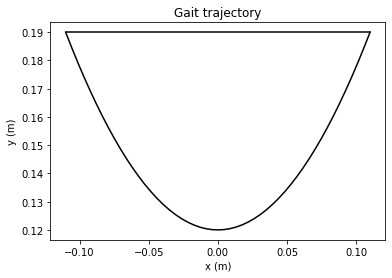

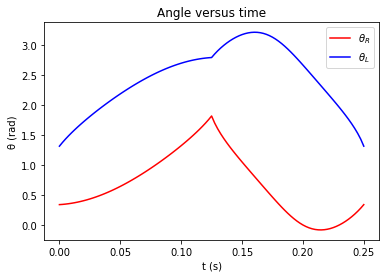

In [8]:
theta1 = gait2angle(0.11,0.19,-0.11,0.19,0,0.12,0.25,0.5,100,0)

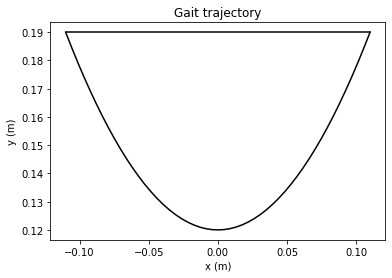

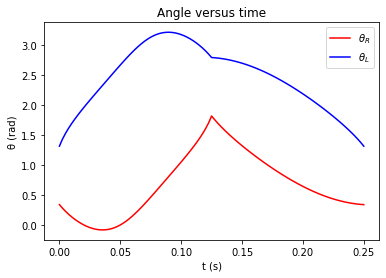

In [9]:
theta2 = gait2angle(0.11,0.19,-0.11,0.19,0,0.12,0.25,0.5,100,1)

# 2 Precompute and interpolate the transform funtions

## 2.1 define trajectory parameters

In [353]:
y_shift = 0.02
x_pos = 0.07
x_on = x_pos
y_on = 0.2-y_shift
x_off = -x_pos
y_off = 0.2-y_shift
x_sw = 0
y_sw = 0.08

y_origin = (y_off + y_sw)/2
x_origin = (x_on + x_off)/2

psi_left = sp.atan2((y_off-y_origin),(x_off-x_origin))
psi_right = sp.atan2((y_on-y_origin),(x_on-x_origin))

x = np.array([x_on-x_origin,x_off-x_origin])
y = np.array([y_on-y_origin,y_off-y_origin])
z_st = np.polyfit(x, y, deg = 1)
poly_st = np.poly1d(z_st)
y_st = z_st[1]

x = np.array([x_off-x_origin,x_sw-x_origin,x_on-x_origin])
y = np.array([y_off-y_origin,y_sw-y_origin,y_on-y_origin])
z_sw = np.polyfit(x, y, deg = 2)
poly_sw = np.poly1d(z_sw)
y_sw = z_sw

## 2.2 define ψ to motor angle function & get current ψ function

In [354]:
# ψ to motor angle function for left odrive
def psi2angleL(psi,x_on=x_on,y_on=y_on,x_off=x_off,y_off=y_off,x_sw=x_sw,y_sw=y_sw,x_origin=x_origin,y_origin=y_origin):

    #whether psi matches the swing or stance
    if psi_right<psi<psi_left:
        #calculate the x,y position related to psi
        if psi == sp.pi/2 or psi == np.pi/2:
            cal_x = 0
        else:
            x = sp.symbols('x')
            cal_x = y_st/sp.tan(psi)
        cal_y = y_st
    else:
        x = sp.symbols('x')
        cal_x = sp.solve(sp.tan(psi) - poly_sw(x)/x,x)
        if psi == sp.pi/2*3 or psi == np.pi/2*3:
            cal_x = 0 
        elif sp.pi/2<psi<sp.pi/2*3:
            if cal_x[0]<0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        elif psi>sp.pi/2*3 or psi<sp.pi/2:
            if cal_x[0]>=0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        cal_y = poly_sw(cal_x)
    
    cal_x = cal_x + x_origin
    cal_y = cal_y + y_origin
        
    theta_motor = fsolve(lambda x: IK_constraint_eqn(x, cal_x, cal_y, l1, l2,w), (0,np.pi))    
    
    return(theta_motor)

In [355]:
# ψ to motor angle function for right odrive
def psi2angleR(psi,x_on=x_on,y_on=y_on,x_off=x_off,y_off=y_off,x_sw=x_sw,y_sw=y_sw,x_origin=x_origin,y_origin=y_origin):

    #whether psi matches the swing or stance
    if psi_right<psi<psi_left:
        #calculate the x,y position related to psi
        if psi == sp.pi/2 or psi == np.pi/2:
            cal_x = 0
        else:
            x = sp.symbols('x')
            cal_x = sp.solve(sp.tan(psi) - poly_st(x)/x,x)[0]
        cal_y = poly_st(cal_x)
    else:
        x = sp.symbols('x')
        cal_x = sp.solve(sp.tan(psi) - poly_sw(x)/x,x)
        if psi == sp.pi/2*3 or psi == np.pi/2*3:
            cal_x = 0 
        elif sp.pi/2<psi<sp.pi/2*3:
            if cal_x[0]<0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        elif psi>sp.pi/2*3 or psi<sp.pi/2:
            if cal_x[0]>=0:
                cal_x = cal_x[0]
            else:
                cal_x = cal_x[1]
        else:
            cal_x = 0 
        cal_y = poly_sw(cal_x)
    
    cal_x = -(cal_x + x_origin)
    cal_y = cal_y + y_origin
        
    theta_motor = fsolve(lambda x: IK_constraint_eqn(x, cal_x, cal_y, l1, l2,w), (0,np.pi))    
    
    return(theta_motor)

## 2.3 precompute the function (input is motor_θ and output are x and y)

In [356]:
N_int = 100
thetaL_int, thetaR_int = np.mgrid[0:2*np.pi+2*np.pi/N_int:2*np.pi/N_int, -np.pi:np.pi+2*np.pi/N_int:2*np.pi/N_int]

In [357]:
#%%time
#generate points for the Right leg    
x_L = np.zeros((N_int+1,N_int+1))
y_L = np.zeros((N_int+1,N_int+1))
a = 0

for i in np.arange(0,2*np.pi+2*np.pi/N_int,2*np.pi/N_int):
    b = 0
    for j in np.arange(-np.pi,np.pi+2*np.pi/N_int,2*np.pi/N_int):
        [x,y] = FK_fast.subs([(thetaL_sym, i), (thetaR_sym, j)])
        x = x-x_origin
        y = y-y_origin
        x_L[a,b] = x
        y_L[a,b] = y
        b = b+1
    a = a+1

In [358]:
np.save('x_L.npy',x_L)
np.save('y_L.npy',y_L)

In [359]:
x_L = np.load('x_L.npy')
y_L = np.load('y_L.npy')

In [360]:
#%%time
tck_getxL = interpolate.bisplrep(thetaL_int, thetaR_int, x_L,s=0.01)
tck_getyL = interpolate.bisplrep(thetaL_int, thetaR_int, y_L,s=0.01)

In [361]:
# %%time
# #generate points for the Right leg    
x_R = np.zeros((N_int+1,N_int+1))
y_R = np.zeros((N_int+1,N_int+1))
a = 0
for i in np.arange(0,2*np.pi+2*np.pi/N_int,2*np.pi/N_int):
    b = 0
    for j in np.arange(-np.pi,np.pi+2*np.pi/N_int,2*np.pi/N_int):
        [x,y] = FK_fast.subs([(thetaL_sym, i), (thetaR_sym, j)])
        x = -(x-x_origin)
        y = y-y_origin
        x_R[a,b] = x
        y_R[a,b] = y
        b = b+1
    a = a+1

In [362]:
np.save('x_R.npy',x_R)
np.save('y_R.npy',y_R)

In [363]:
x_R = np.load('x_R.npy')
y_R = np.load('y_R.npy')

In [364]:
#%%time
tck_getxR = interpolate.bisplrep(thetaL_int, thetaR_int, x_R,s=0.01)
tck_getyR = interpolate.bisplrep(thetaL_int, thetaR_int, y_R,s=0.01)

In [365]:
def xy2psi(x,y):
    if x>0 and y>=0:
        real_psi = sp.atan(y/x)
    elif x>0 and y<0:
        real_psi = sp.atan(y/x) + 2*sp.pi
    elif x<0:
        real_psi = sp.atan(y/x) + sp.pi
    elif x==0 and y>0:
        real_psi = sp.pi/2
    else:
        real_psi = sp.pi/2*3
    return(real_psi)

## 2.4 precompute the function (input is ψ and output is motor_θ)

In [366]:
# %%time
# # use interpolation to genetate funcition to match psi and motor thetas
N_int = 50
psi_int = np.arange(0,2*np.pi+np.pi/N_int*2,np.pi/N_int*2)

#generate points for the Left leg
j = 0
theta_intL = np.zeros((N_int+1,2))
for i in psi_int:
    theta_intL[j] = psi2angleL(i)
    j = j+1
    
#generate points for the Right leg    
j = 0
theta_intR = np.zeros((N_int+1,2))
for i in psi_int:
    theta_intR[j] = psi2angleR(i)
    j = j+1

In [367]:
np.save('theta_intL.npy',theta_intL)
np.save('theta_intR.npy',theta_intR)

In [368]:
theta_intL = np.load('theta_intL.npy')
theta_intR = np.load('theta_intR.npy')

In [369]:
#%%time
tck_L0=interpolate.splrep(psi_int,theta_intL[:,0])
tck_L1=interpolate.splrep(psi_int,theta_intL[:,1])
tck_R0=interpolate.splrep(psi_int,theta_intR[:,0])
tck_R1=interpolate.splrep(psi_int,theta_intR[:,1])

## 2.5 define phase change function for CPG

In [370]:
# consider right leg moves faster than left leg 
# psi from psi_right(o,pi/2) to psi_left(pi/2,pi) to psi_right(2*pi,5/2*pi)
psi_st = np.float64(np.array([psi_right,psi_left]))
delta_st = np.float64(np.array([psi_left-psi_right,sp.pi*2-(psi_left-psi_right)]))
z = np.polyfit(psi_st, delta_st, deg = 1)
poly_delta_st = np.poly1d(z)

psi_sw = np.float64(np.array([psi_left,psi_right+sp.pi*2]))
delta_sw = np.float64(np.array([sp.pi*2-(psi_left-psi_right),psi_left-psi_right]))
z = np.polyfit(psi_sw, delta_sw, deg = 1)
poly_delta_sw = np.poly1d(z)

# 3 Ready to use Odrive

In [28]:
import time

import odrive
import odrive.utils
import odrive.enums

## 3.1 Connect to ODrive

In [234]:
# odrv0 = odrive.find_any(serial_number = '306639703235', timeout = 20)
# if odrv0 is not None:
#     print('Connected!')
#     print('Odrive serial {}'.format(odrv0.serial_number))
    
#     m0 = odrv0.axis0.motor.is_calibrated
#     m1 = odrv0.axis1.motor.is_calibrated
    
#     print('Motor 0 calibrated: {}'.format(m0))
#     print('Motor 1 calibrated: {}'.format(m1))    
    
# else:
#     print('Not connected')

Connected!
Odrive serial 53215608451637
Motor 0 calibrated: False
Motor 1 calibrated: False


In [235]:
# odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
# odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [236]:
# odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
# odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

In [174]:
# odrv1 = odrive.find_any(serial_number = '3081396C3235', timeout = 20)
# if odrv1 is not None:
#     print('Connected!')
#     print('Odrive serial {}'.format(odrv1.serial_number))
    
#     m0 = odrv1.axis0.motor.is_calibrated
#     m1 = odrv1.axis1.motor.is_calibrated
    
#     print('Motor 0 calibrated: {}'.format(m0))
#     print('Motor 1 calibrated: {}'.format(m1))    
    
# else:
#     print('Not connected')

In [237]:
odrv0 = odrive.find_any(serial_number = '306639703235', timeout = 20)
odrv1 = odrive.find_any(serial_number = '3081396C3235', timeout = 20)
if odrv0 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv0.serial_number))
    
    m0 = odrv0.axis0.motor.is_calibrated
    m1 = odrv0.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')

if odrv1 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv1.serial_number))
    
    m0 = odrv1.axis0.motor.is_calibrated
    m1 = odrv1.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')

Connected!
Odrive serial 53215608451637
Motor 0 calibrated: False
Motor 1 calibrated: False
Connected!
Odrive serial 53331572306485
Motor 0 calibrated: False
Motor 1 calibrated: True


## 3.2 preparation before moving motor

In [342]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [340]:
curr_limit_all = 30
odrv0.axis0.motor.config.current_lim =curr_limit_all
odrv0.axis1.motor.config.current_lim =curr_limit_all
odrv1.axis0.motor.config.current_lim =curr_limit_all
odrv1.axis1.motor.config.current_lim =curr_limit_all

In [250]:
odrv0.axis0.controller.config.vel_limit = 200000000
odrv0.axis1.controller.config.vel_limit = 200000000
odrv1.axis0.controller.config.vel_limit = 200000000
odrv1.axis1.controller.config.vel_limit = 200000000

### Calibrate

In [241]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

time.sleep(15)
print('\t Odrv 1_Motor 0 calibration result: {} \r\n'.format(odrv1.axis0.motor.is_calibrated), 
      '\t Odrv 1_Motor 1 calibration result: {}'.format(odrv1.axis1.motor.is_calibrated))

print('\t Odrv 0_Motor 0 calibration result: {} \r\n'.format(odrv0.axis0.motor.is_calibrated), 
      '\t Odrv 0_Motor 1 calibration result: {}'.format(odrv0.axis1.motor.is_calibrated))

	 Odrv 1_Motor 0 calibration result: True 
 	 Odrv 1_Motor 1 calibration result: True
	 Odrv 0_Motor 0 calibration result: True 
 	 Odrv 0_Motor 1 calibration result: True


In [334]:
odrv0.axis0.controller.error=0
odrv0.axis0.motor.error=0
odrv0.axis0.encoder.error=0
odrv0.axis0.error=0

odrv0.axis1.controller.error=0
odrv0.axis1.motor.error=0
odrv0.axis1.encoder.error=0
odrv0.axis1.error=0

odrv1.axis0.controller.error=0
odrv1.axis0.motor.error=0
odrv1.axis0.encoder.error=0
odrv1.axis0.error=0

odrv1.axis1.controller.error=0
odrv1.axis1.motor.error=0
odrv1.axis1.encoder.error=0
odrv1.axis1.error=0

In [335]:
print('odrv0 errors')
odrive.utils.dump_errors(odrv0)
print('\nodrv1 errors')
odrive.utils.dump_errors(odrv1)

odrv0 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error

odrv1 errors
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


## Put the legs on NOW! (before running more code below)

In [336]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

### define angle to position function & position to angle function

In [305]:
# get motor parameters
motor_cpr0 = (odrv0.axis0.encoder.config.cpr,odrv0.axis1.encoder.config.cpr)
pos_zero0 = ([odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate])
motor_cpr1 = (odrv1.axis0.encoder.config.cpr,odrv1.axis1.encoder.config.cpr)
pos_zero1 = ([odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate])

In [306]:
# angle to position for 2 odrives
# pos = np.zeros(shape=(1,2))
def angle2posL(theta, pos_zero = pos_zero0, motor_cpr = motor_cpr0, zero_theta = (0,np.pi)):
    pos = np.zeros(shape=(1,2))
    pos[0,0] = -(theta[0] - zero_theta[0])/(2*np.pi)*motor_cpr[0] + pos_zero[0]
    pos[0,1] = -(theta[1] - zero_theta[1])/(2*np.pi)*motor_cpr[1] + pos_zero[1]    
    return (pos)
def angle2posR(theta, pos_zero = pos_zero1, motor_cpr = motor_cpr1, zero_theta = (0,np.pi)):
    pos = np.zeros(shape=(1,2))
    pos[0,0] = -(theta[0] - zero_theta[0])/(2*np.pi)*motor_cpr[0] + pos_zero[0]
    pos[0,1] = -(theta[1] - zero_theta[1])/(2*np.pi)*motor_cpr[1] + pos_zero[1]    
    return (pos)

In [307]:
# position to angle for 2 odrives
# angle = np.zeros(shape=(1,2))
def pos2angleL(pos, motor_cpr = motor_cpr0, pos_zero = pos_zero0, zero_theta = (0,np.pi)):
    angle = np.zeros(shape=(1,2))
    angle[0,0] = -2*np.pi*(pos[0] - pos_zero[0])/motor_cpr[0]+zero_theta[0]
    angle[0,1] = -2*np.pi*(pos[1] - pos_zero[1])/motor_cpr[1]+zero_theta[1]
    return (angle)

def pos2angleR(pos, motor_cpr = motor_cpr1, pos_zero = pos_zero1, zero_theta = (0,np.pi)):
    angle = np.zeros(shape=(1,2))
    angle[0,0] = -2*np.pi*(pos[0] - pos_zero[0])/motor_cpr[0]+zero_theta[0]
    angle[0,1] = -2*np.pi*(pos[1] - pos_zero[1])/motor_cpr[1]+zero_theta[1]
    return (angle)

## 3.3 Get legs on and start moving motors

### move legs to start points

In [371]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

In [372]:
# move left leg to on_point; ritht leg to off_point
theta_startL = fsolve(lambda x: IK_constraint_eqn(x, x_on, y_on, l1, l2,w), (0,np.pi))
theta_startR = fsolve(lambda x: IK_constraint_eqn(x, -x_off, y_off, l1, l2,w), (0,np.pi))

In [373]:
odrv0.axis0.controller.pos_setpoint = angle2posL(theta_startL)[0,0]
odrv0.axis1.controller.pos_setpoint = angle2posL(theta_startL)[0,1]
odrv1.axis0.controller.pos_setpoint = angle2posR(theta_startR)[0,0]
odrv1.axis1.controller.pos_setpoint = angle2posR(theta_startR)[0,1]

### move motors use CPG

In [ ]:
# aL, aR represent to the angles related to the supposed coordinate system
w_speed = 10
A_L = 0
A_R = 0
delta_t = 0.005

start = time.time()
t_curr = 0

#get the initial point
real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
    
real_angle_L = pos2angleL(real_pos_L)
real_angle_R = pos2angleR(real_pos_R)

xL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getxL)
yL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getyL)
xR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getxR)
yR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getyR)

aL0 = xy2psi(xL,yL)
aR0 = xy2psi(xR,yR)

#start moving
while(t_curr < 20):
    t_curr = (time.time() - start)
    
    real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
    real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)
    
    real_angle_L = pos2angleL(real_pos_L)
    real_angle_R = pos2angleR(real_pos_R)
    
    xL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getxL)
    yL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getyL)
    xR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getxR)
    yR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getyR)
#     print('xL, yL is ({},{})'.format(xL, yL))
#     print('xR, yR is ({},{})'.format(xR, yR))
    
    aL = xy2psi(xL,yL)
    aR = xy2psi(xR,yR)
    
    if psi_right<=aL<=psi_left:
        delta_psi = poly_delta_st(aL)
    elif aL>psi_left:
        delta_psi = poly_delta_sw(aL)
    else:
        delta_psi = poly_delta_sw(aL+2*np.pi)
    
    if aL>aR:
        aR = aR + sp.pi*2
#     print('aL is {}, aR is {}'.format(np.float(aL), np.float(aR)))

    aL0 = aL0 + delta_t*(w_speed+A_L*sp.sin((aR-aL)-delta_psi))
    aR0 = aR0 + delta_t*(w_speed+A_R*sp.sin(delta_psi-(aR-aL)))
    
    aL1 = aL0 % (sp.pi*2)
    aR1 = aR0 % (sp.pi*2)
    
    motor_theta_L = (interpolate.splev(np.float(aL1),tck_L0),interpolate.splev(np.float(aL1),tck_L1))
    motor_theta_R = (interpolate.splev(np.float(aR1),tck_R0),interpolate.splev(np.float(aR1),tck_R1))
    
    odrv0.axis0.controller.pos_setpoint = angle2posL(motor_theta_L)[0,0]
    odrv0.axis1.controller.pos_setpoint = angle2posL(motor_theta_L)[0,1]
    odrv1.axis0.controller.pos_setpoint = angle2posR(motor_theta_R)[0,0]
    odrv1.axis1.controller.pos_setpoint = angle2posR(motor_theta_R)[0,1]



In [347]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv1.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [83]:
odrv0.axis0.controller.error=0
odrv0.axis0.motor.error=0
odrv0.axis0.encoder.error=0
odrv0.axis0.error=0

odrv0.axis1.controller.error=0
odrv0.axis1.motor.error=0
odrv0.axis1.encoder.error=0
odrv0.axis1.error=0

odrv1.axis0.controller.error=0
odrv1.axis0.motor.error=0
odrv1.axis0.encoder.error=0
odrv1.axis0.error=0

odrv1.axis1.controller.error=0
odrv1.axis1.motor.error=0
odrv1.axis1.encoder.error=0
odrv1.axis1.error=0

In [37]:
%qtconsole

In [96]:
real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)

real_angle_L = pos2angleL(real_pos_L)
real_angle_R = pos2angleR(real_pos_R)

xL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getxL)
yL = interpolate.bisplev(real_angle_L[0,1],real_angle_L[0,0], tck_getyL)
xR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getxR)
yR = interpolate.bisplev(real_angle_R[0,1],real_angle_R[0,0], tck_getyR)
print('xL, yL is ({},{})'.format(xL, yL))
print('xR, yR is ({},{})'.format(xR, yR))

aL = xy2psi(xL,yL)
aR = xy2psi(xR,yR)

print('aL is {}, aR is {}'.format(np.float(aL), np.float(aR)))

xL, yL is (0.016942527937638906,0.0353312624194275)
xR, yR is (-0.016942527937638906,0.0353312624194275)
aL is 1.1236554733429744, aR is 2.0179371802468187


In [221]:
real_pos_L = (odrv0.axis0.encoder.pos_estimate,odrv0.axis1.encoder.pos_estimate)
real_pos_R = (odrv1.axis0.encoder.pos_estimate,odrv1.axis1.encoder.pos_estimate)

print('real_pos_L', real_pos_L)
# print('real_pos_R', real_pos_R)


real_pos_L (-3636.15625, -1555.765625)
